In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev
from scipy.stats import t

In [2]:
data = pd.read_csv('quantium/QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 19.2+ MB


In [4]:
data.isna().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

### Select control stores

The client has selected stores 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period

In [5]:
data['YEARMONTH'] = data['DATE'].str[:7].str.replace('-', '')

In [6]:
data['YEARMONTH'] = pd.to_numeric(data['YEARMONTH'])
data['YEARMONTH'].head()

0    201810
1    201809
2    201903
3    201903
4    201811
Name: YEARMONTH, dtype: int64

In [7]:
totSales = data.groupby(['STORE_NBR', 'YEARMONTH'])['TOT_SALES'].sum()
nCustomers = data.groupby(['STORE_NBR', 'YEARMONTH'])['LYLTY_CARD_NBR'].nunique()
nTxnPerCust = data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique() / data.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
nChipsPerTxn = data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique()
avgPricePerUnit = data.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum()

In [8]:
df = [totSales, nCustomers, nTxnPerCust, nChipsPerTxn, avgPricePerUnit]
measureOverTime = pd.concat(df, join = 'outer', axis = 1)
measureOverTime.head()

TOT_SALES  LYLTY_CARD_NBR         0         1         2
STORE_NBR YEARMONTH                                                         
1         201807         206.9              49  1.061224  1.192308  3.337097
          201808         176.1              42  1.023810  1.255814  3.261111
          201809         278.8              59  1.050847  1.209677  3.717333
          201810         188.1              44  1.022727  1.288889  3.243103
          201811         192.6              46  1.021739  1.212766  3.378947

In [9]:
measureOverTime.rename(columns = {'TOT_SALES': 'totSales', 'LYLTY_CARD_NBR': 'nCustomers', 0: 'nChipsPerCust', 1: 'nChipsPerTxn', 2: 'avgPricePerUnit'}, inplace = True)
measureOverTime.head()

totSales  nCustomers  nChipsPerCust  nChipsPerTxn  \
STORE_NBR YEARMONTH                                                      
1         201807        206.9          49       1.061224      1.192308   
          201808        176.1          42       1.023810      1.255814   
          201809        278.8          59       1.050847      1.209677   
          201810        188.1          44       1.022727      1.288889   
          201811        192.6          46       1.021739      1.212766   

                     avgPricePerUnit  
STORE_NBR YEARMONTH                   
1         201807            3.337097  
          201808            3.261111  
          201809            3.717333  
          201810            3.243103  
          201811            3.378947

drop stores without full observations

In [10]:
a = pd.pivot_table(data, index = 'STORE_NBR', columns = 'YEARMONTH', values = 'TXN_ID', aggfunc = 'count')
a.head()


YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0


In [11]:
a.isna().sum()

YEARMONTH
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

In [12]:
null_store = a[a.isnull().any(axis=1)].index.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [13]:
measureOverTime.reset_index(inplace =True)

In [14]:
measureOverTime = measureOverTime[~measureOverTime['STORE_NBR'].isin(null_store)]

In [15]:
len(measureOverTime)

3120

### new dataframe that takes data before trial period

In [16]:
preTrialMeasures = measureOverTime.loc[measureOverTime['YEARMONTH'] < 201902, :]
len(preTrialMeasures)

1820

In [17]:
# function which calculates the correlation between trial store and other stores based on a single metric
def calc_corr(Table, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation':[] })
    a = Table.loc[Table['STORE_NBR']== trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    
    storeNumbers =Table['STORE_NBR'].unique()
    for i in storeNumbers:
        b = Table.loc[Table['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)}, ignore_index = True)
    return output

In [18]:
#  function which calculates a standardised magnitude difference 
def calc_mag(Table, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude' : []})
    a = Table.loc[Table['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = Table['STORE_NBR'].unique()
    for i in storeNumbers:
        b = Table.loc[Table['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output = output.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d}, ignore_index = True)
    return output

In [19]:
#correlation for sales and customers with trial store 77
corr_nSales = calc_corr(preTrialMeasures, 'totSales', 77)
corr_nCustomers = calc_corr(preTrialMeasures, 'nCustomers', 77)

#magnitude for sales and customers with trial store 77
magnitude_nSales = calc_mag(preTrialMeasures, 'totSales', 77)
magnitude_nCustomers = calc_mag(preTrialMeasures, 'nCustomers', 77)



for nSales

In [20]:
print(corr_nSales.head())
magnitude_nSales.head()

   Store1  Store2  Correlation
0    77.0     1.0     0.075218
1    77.0     2.0    -0.263079
2    77.0     3.0     0.806644
3    77.0     4.0    -0.263300
4    77.0     5.0    -0.110652


,Store1,Store2,Magnitude
0,77.0,1.0,0.408163
1,77.0,2.0,0.590119
2,77.0,3.0,0.522914
3,77.0,4.0,0.644934
4,77.0,5.0,0.516320


In [21]:
#concatenate score for nSales
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis =1)

In [22]:
#calculating weighted average

score_nSales['scoreNSales'] = 0.5 * score_nSales['Correlation'] + (0.5 * score_nSales['Magnitude'])
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,77.0,1.0,0.075218,0.408163,0.241691
1,77.0,2.0,-0.263079,0.590119,0.163520
2,77.0,3.0,0.806644,0.522914,0.664779
3,77.0,4.0,-0.263300,0.644934,0.190817
4,77.0,5.0,-0.110652,0.516320,0.202834


for nCustomers now

In [23]:
print(corr_nCustomers.head())
magnitude_nCustomers.head()

   Store1  Store2  Correlation
0    77.0     1.0     0.322168
1    77.0     2.0    -0.572051
2    77.0     3.0     0.834207
3    77.0     4.0    -0.295639
4    77.0     5.0     0.370659


,Store1,Store2,Magnitude
0,77.0,1.0,0.663866
1,77.0,2.0,0.471429
2,77.0,3.0,0.489796
3,77.0,4.0,0.498258
4,77.0,5.0,0.512605


In [24]:
#concatenate score for nCustomers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis =1)

In [25]:
#calculating weighted average

score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['Correlation'] + (0.5 * score_nCustomers['Magnitude'])
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,77.0,1.0,0.322168,0.663866,0.493017
1,77.0,2.0,-0.572051,0.471429,-0.050311
2,77.0,3.0,0.834207,0.489796,0.662002
3,77.0,4.0,-0.295639,0.498258,0.101310
4,77.0,5.0,0.370659,0.512605,0.441632


In [26]:
#Index both 'score_nSales' and 'score_nCustomers' dataframe to aid merging

score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [27]:
#new dataframe 'score_Control' which takes the average of 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
77.0   1.0        0.241691    0.493017
       2.0        0.163520   -0.050311
       3.0        0.664779    0.662002
       4.0        0.190817    0.101310
       5.0        0.202834    0.441632
...                    ...         ...
       268.0      0.387272    0.470473
       269.0      0.121684    0.005090
       270.0      0.453489    0.202710
       271.0      0.348289    0.174100
       272.0      0.320626    0.384336

[260 rows x 2 columns]

In [28]:
#adding a column into control_score which gives a finalscore ( average of sales and customer score)
score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
77.0   1.0        0.241691    0.493017           0.367354
       2.0        0.163520   -0.050311           0.056604
       3.0        0.664779    0.662002           0.663390
       4.0        0.190817    0.101310           0.146064
       5.0        0.202834    0.441632           0.322233

In [29]:
#Now we sort by final score to get the control store for trial store 77
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()


scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
77.0   233.0      0.697290    0.816607           0.756949
       71.0       0.789497    0.663123           0.726310
       84.0       0.656972    0.715000           0.685986
       119.0      0.636046    0.729729           0.682887
       115.0      0.708347    0.645155           0.676751

### Store 233 is the control store for trial store 77

In [30]:
#new dataframe from preTrialMaasures Df
pastSales = preTrialMeasures

store_type = []

for i in pastSales['STORE_NBR']:
    if i == 77:
        store_type.append('Trial Store')
    elif i == 233:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/1717584557.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores


In [31]:
#create a transaction month column
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/3201636428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


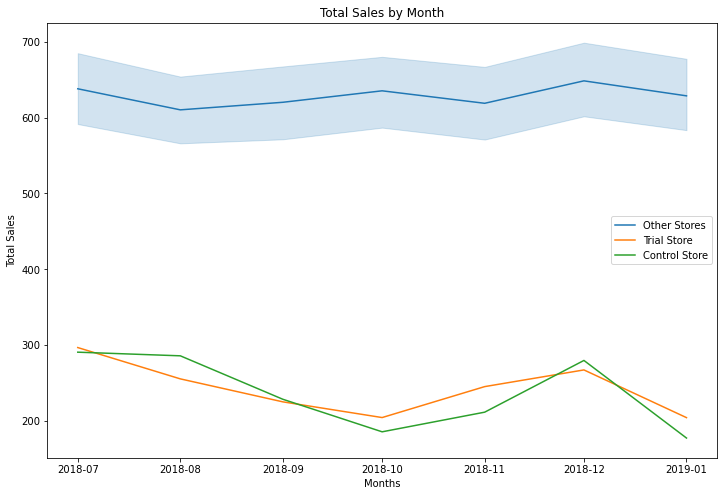

In [32]:
#  'totSales' visualisation for control store, trial store and other stores

plt.figure(figsize =(12, 8))
g=sns.lineplot(data= pastSales, x = 'TransactionMonth', y='totSales', hue='store_type')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Total Sales by Month')
plt.savefig('Total Sales by Month store 77.png')

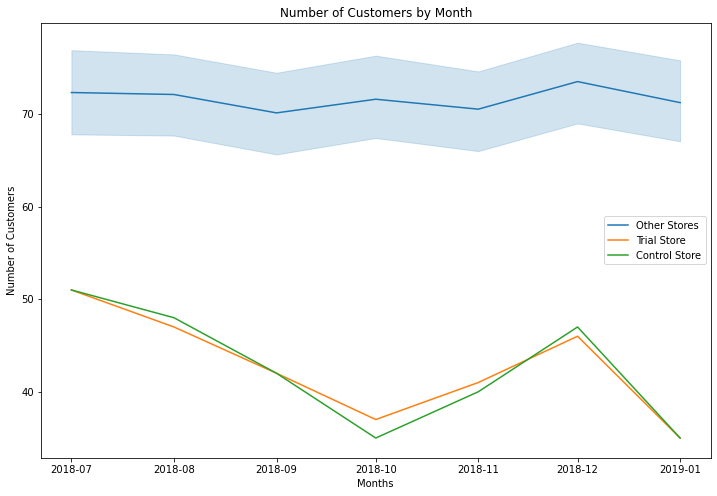

In [33]:
#  'nCustomers' visualisation for control store, trial store and other stores
plt.figure(figsize =(12, 8))
g =sns.lineplot(data= pastSales, x = 'TransactionMonth', y='nCustomers', hue='store_type')
plt.ylabel('Number of Customers')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Number of Customers by Month')
plt.savefig('Number of Customers by Month store 77.png')

Assessment of trial for trial strore 77

In [34]:
# create scaling factor; compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control stor

trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.023617303289553

In [35]:
#create new df from measureovertime (before we filtered with pretrial date)
scaledControlSales = measureOverTime
scaledControlSales.head()


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [36]:
#we only want for the control store
scaledControlSales = scaledControlSales[scaledControlSales['STORE_NBR'] == 233]
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
2699,233,201807,290.7,51,1.058824,1.629630,3.303409
2700,233,201808,285.9,48,1.041667,1.600000,3.573750
2701,233,201809,228.6,42,1.071429,1.555556,3.265714
2702,233,201810,185.7,35,1.028571,1.555556,3.316071
2703,233,201811,211.6,40,1.025000,1.512195,3.412903


In [37]:
# new colum 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/2095262402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421


In [38]:
# Create 'percentageDiff' dataframe which computes diff between controledsales and trial sales

#control store 'totSales'
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == 77, 'totSales']
trialSales.reset_index(drop = True, inplace = True)

# Concatenate
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)



percentageDiff

,YEARMONTH,controlSales,trialSales
0,201807,297.565550,296.8
1,201808,292.652187,255.5
2,201809,233.998916,225.2
3,201810,190.085733,204.5
4,201811,216.597421,245.3
5,201812,286.408121,267.3
6,201901,181.692071,204.4
7,201902,249.762622,235.0
8,201903,203.802205,278.5
9,201904,162.345704,263.5


In [39]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


In [40]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev
#standard deviation between percentage diff before trial period

0.04994076264142537

In [41]:
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [42]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     1.183534
8     7.339116
9    12.476373
Name: tValue, dtype: float64

In [43]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)


1.8945786050613054

In [44]:
#recall ScaledControlSales
scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/801860965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales,TransactionMonth
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550,2018-07-01
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187,2018-08-01
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916,2018-09-01
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733,2018-10-01
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421,2018-11-01


In [45]:
#visualisation
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales.head()

,Control Sales
TransactionMonth,
2018-07-01,297.565550
2018-08-01,292.652187
2018-09-01,233.998916
2018-10-01,190.085733
2018-11-01,216.597421


In [46]:
#new 'TransationMonth'column under 'measureOverTime' dataframe

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEARMONTH'].astype(str), format = '%Y%m')

#extract totsales for trial store from measureOvertime to get trial sales
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == 77, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales.head()

,Trial Sales
TransactionMonth,
2018-07-01,296.8
2018-08-01,255.5
2018-09-01,225.2
2018-10-01,204.5
2018-11-01,245.3


In [47]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,297.565550,267.844249,327.286851
2018-08-01,292.652187,263.421640,321.882734
2018-09-01,233.998916,210.626747,257.371084
2018-10-01,190.085733,171.099680,209.071786
2018-11-01,216.597421,194.963341,238.231502


In [48]:
combineSales = pd.concat([controlSales, trialSales], axis=1)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,297.565550,267.844249,327.286851,296.8
2018-08-01,292.652187,263.421640,321.882734,255.5
2018-09-01,233.998916,210.626747,257.371084,225.2
2018-10-01,190.085733,171.099680,209.071786,204.5
2018-11-01,216.597421,194.963341,238.231502,245.3
2018-12-01,286.408121,257.801241,315.015001,267.3
2019-01-01,181.692071,163.544390,199.839753,204.4
2019-02-01,249.762622,224.815950,274.709294,235.0
2019-03-01,203.802205,183.446130,224.158280,278.5


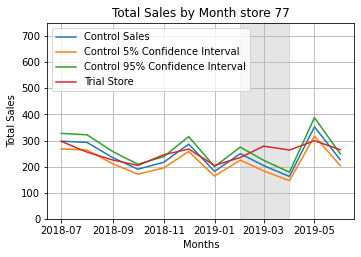

In [49]:
plt.figure(figsize=(5.5, 3.6))
plt.plot(combineSales)
plt.title('Total Sales by Month store 77')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.ylim(0, 750)
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)
plt.axvspan('2019-02-01', '2019-04-01', color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.savefig('Total Sales by Month store 77 ci.png')
plt.show()


Trial in store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in the two of the 3 trial months.

In [50]:
# Now let's move on to 'nCustomers'
# First, compute scaling factor
# Let's call this variable 'scalingFactorCustomers'

trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0033557046979866

In [51]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == 233]
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/1486473935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01,51.171141
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01,48.161074
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01,42.140940
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,2018-10-01,35.117450
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,2018-11-01,40.134228


In [52]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == 77, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,51.171141,51
1,201808,48.161074,47
2,201809,42.140940,42
3,201810,35.117450,37
4,201811,40.134228,41
5,201812,47.157718,46
6,201901,35.117450,35
7,201902,45.151007,45
8,201903,40.134228,50
9,201904,30.100671,47


In [53]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


In [54]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.018240748558243945

In [55]:
#we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [56]:
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     0.183352
8    13.476388
9    30.778725
Name: tValue, dtype: float64

In [57]:
t.isf(0.05, dof)

1.8945786050613054

In [58]:
controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,51.171141
2018-08-01,48.161074
2018-09-01,42.140940
2018-10-01,35.117450
2018-11-01,40.134228
2018-12-01,47.157718
2019-01-01,35.117450
2019-02-01,45.151007
2019-03-01,40.134228


In [59]:
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == 77, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,51
2018-08-01,47
2018-09-01,42
2018-10-01,37
2018-11-01,41
2018-12-01,46
2019-01-01,35
2019-02-01,45
2019-03-01,50


In [60]:
controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,51.171141,49.304341,53.037941
2018-08-01,48.161074,46.404086,49.918062
2018-09-01,42.140940,40.603575,43.678304
2018-10-01,35.117450,33.836313,36.398587
2018-11-01,40.134228,38.670071,41.598385
2018-12-01,47.157718,45.437334,48.878102
2019-01-01,35.117450,33.836313,36.398587
2019-02-01,45.151007,43.503830,46.798183
2019-03-01,40.134228,38.670071,41.598385


In [61]:
combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,51.171141,49.304341,53.037941,51
2018-08-01,48.161074,46.404086,49.918062,47
2018-09-01,42.140940,40.603575,43.678304,42
2018-10-01,35.117450,33.836313,36.398587,37
2018-11-01,40.134228,38.670071,41.598385,41
2018-12-01,47.157718,45.437334,48.878102,46
2019-01-01,35.117450,33.836313,36.398587,35
2019-02-01,45.151007,43.503830,46.798183,45
2019-03-01,40.134228,38.670071,41.598385,50


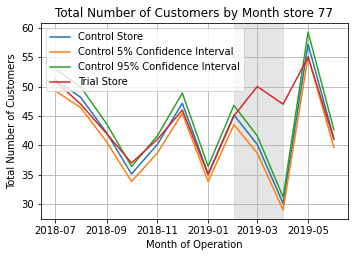

In [62]:
plt.figure(figsize=(5.5, 3.6))
plt.plot(combineCustomers)
plt.title('Total Number of Customers by Month store 77')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')
plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 'upper left')
plt.axvspan('2019-02-01', '2019-04-01', color = 'grey', alpha = 0.2)
# Set grid
plt.grid()
plt.savefig('Total Number of Customers by Month store 77 ci.png')
plt.show()


### Selecting control store for trial 86

In [63]:
#correlation for sales and customers with trial store 86
corr_nSales = calc_corr(preTrialMeasures, 'totSales', 86)
corr_nCustomers = calc_corr(preTrialMeasures, 'nCustomers', 86)

#magnitude for sales and customers with trial store 86
magnitude_nSales = calc_mag(preTrialMeasures, 'totSales', 86)
magnitude_nCustomers = calc_mag(preTrialMeasures, 'nCustomers', 86)


for nSales

In [64]:
print(corr_nSales.head())
magnitude_nSales.head()

   Store1  Store2  Correlation
0    86.0     1.0     0.445632
1    86.0     2.0    -0.403835
2    86.0     3.0    -0.261284
3    86.0     4.0    -0.039035
4    86.0     5.0     0.235159


,Store1,Store2,Magnitude
0,86.0,1.0,0.488334
1,86.0,2.0,0.321131
2,86.0,3.0,0.507515
3,86.0,4.0,0.635654
4,86.0,5.0,0.579835


In [65]:
#concatenate score for nSales
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis =1)

In [66]:
#calculating weighted average

score_nSales['scoreNSales'] = 0.5 * score_nSales['Correlation'] + (0.5 * score_nSales['Magnitude'])
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,86.0,1.0,0.445632,0.488334,0.466983
1,86.0,2.0,-0.403835,0.321131,-0.041352
2,86.0,3.0,-0.261284,0.507515,0.123116
3,86.0,4.0,-0.039035,0.635654,0.298309
4,86.0,5.0,0.235159,0.579835,0.407497


for nCustomers now

In [67]:
print(corr_nCustomers.head())
magnitude_nCustomers.head()

   Store1  Store2  Correlation
0    86.0     1.0     0.485831
1    86.0     2.0    -0.086161
2    86.0     3.0    -0.353786
3    86.0     4.0    -0.169608
4    86.0     5.0    -0.253229


,Store1,Store2,Magnitude
0,86.0,1.0,0.510204
1,86.0,2.0,0.428571
2,86.0,3.0,0.563025
3,86.0,4.0,0.537815
4,86.0,5.0,0.714286


In [68]:
#concatenate score for nCustomers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis =1)

In [69]:
#calculating weighted average

score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['Correlation'] + (0.5 * score_nCustomers['Magnitude'])
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,86.0,1.0,0.485831,0.510204,0.498018
1,86.0,2.0,-0.086161,0.428571,0.171205
2,86.0,3.0,-0.353786,0.563025,0.104620
3,86.0,4.0,-0.169608,0.537815,0.184103
4,86.0,5.0,-0.253229,0.714286,0.230528


In [70]:
#Index both 'score_nSales' and 'score_nCustomers' dataframe to aid merging

score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [71]:
#new dataframe 'score_Control' which takes the average of 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
86.0   1.0        0.466983    0.498018
       2.0       -0.041352    0.171205
       3.0        0.123116    0.104620
       4.0        0.298309    0.184103
       5.0        0.407497    0.230528
...                    ...         ...
       268.0     -0.080126    0.266027
       269.0      0.588661    0.241523
       270.0     -0.106832   -0.058237
       271.0      0.546651    0.432804
       272.0      0.294383    0.139863

[260 rows x 2 columns]

In [72]:
#adding a column into control_score which gives a finalscore ( average of sales and customer score)
score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
86.0   1.0        0.466983    0.498018           0.482500
       2.0       -0.041352    0.171205           0.064927
       3.0        0.123116    0.104620           0.113868
       4.0        0.298309    0.184103           0.241206
       5.0        0.407497    0.230528           0.319013

In [73]:
#Now we sort by final score to get the control store for trial store 86
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
86.0   155.0      0.808106    0.733343           0.770724
       109.0      0.697120    0.742532           0.719826
       114.0      0.631393    0.663384           0.647389
       225.0      0.601841    0.684356           0.643099
       138.0      0.593296    0.660565           0.626930

### Store 155 is the control store for trial store 86

In [74]:
#new dataframe from preTrialMaasures Df
pastSales = preTrialMeasures

store_type = []

for i in pastSales['STORE_NBR']:
    if i == 86:
        store_type.append('Trial Store')
    elif i == 155:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/782112579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [75]:
#create a transaction month column
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/3201636428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


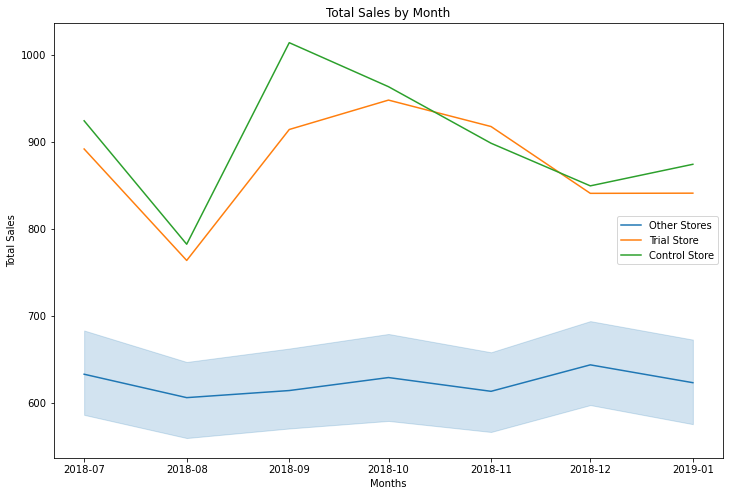

In [76]:
#  'totSales' visualisation for control store, trial store and other stores

plt.figure(figsize =(12, 8))
g=sns.lineplot(data= pastSales, x = 'TransactionMonth', y='totSales', hue='store_type')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Total Sales by Month')
plt.savefig('Total Sales by Month store 86.png')

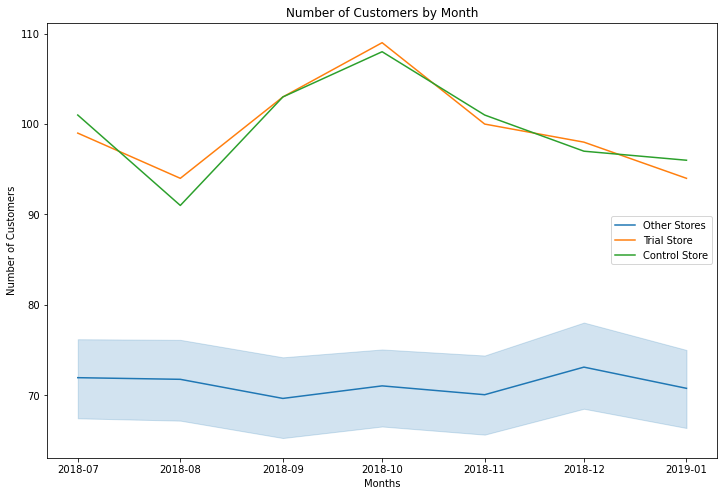

In [77]:
#  'nCustomers' visualisation for control store, trial store and other stores
plt.figure(figsize =(12, 8))
g =sns.lineplot(data= pastSales, x = 'TransactionMonth', y='nCustomers', hue='store_type')
plt.ylabel('Number of Customers')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Number of Customers by Month')
plt.savefig('Number of Customers by Month store 86.png')

Assessment of trial for trial store 86

In [78]:
# create scaling factor; compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control stor

trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

0.9700651481287743

In [79]:
#create new df from measureovertime (before we filtered with pretrial date)
scaledControlSales = measureOverTime
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [80]:
#we only want for the control store
scaledControlSales = scaledControlSales[scaledControlSales['STORE_NBR'] == 155]
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01


In [81]:
# new colum 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/2095262402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,984.034086
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01,934.948790
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01,871.894555


In [82]:
# Create 'percentageDiff' dataframe which computes diff between controledsales and trial sales

#control store 'totSales'
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == 86, 'totSales']
trialSales.reset_index(drop = True, inplace = True)

# Concatenate
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)



percentageDiff

,YEARMONTH,controlSales,trialSales
0,201807,896.922236,892.20
1,201808,759.269991,764.05
2,201809,984.034086,914.60
3,201810,934.948790,948.40
4,201811,871.894555,918.00
5,201812,824.361363,841.20
6,201901,848.418979,841.40
7,201902,864.522060,913.20
8,201903,780.320405,1026.80
9,201904,819.317024,848.20


In [83]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


In [84]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev
#standard deviation between percentage diff before trial period

0.025833952854772368

In [85]:
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [86]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     2.179542
8    12.226922
9     1.364580
Name: tValue, dtype: float64

In [87]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)


1.8945786050613054

In [88]:
#recall ScaledControlSales
scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/801860965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,984.034086
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01,934.948790
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01,871.894555


In [89]:
#visualisation
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales.head()

,Control Sales
TransactionMonth,
2018-07-01,896.922236
2018-08-01,759.269991
2018-09-01,984.034086
2018-10-01,934.948790
2018-11-01,871.894555


In [90]:
#new 'TransationMonth'column under 'measureOverTime' dataframe

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEARMONTH'].astype(str), format = '%Y%m')

#extract totsales for trial store from measureOvertime to get trial sales
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == 86, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)

In [91]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,896.922236,850.580142,943.264329
2018-08-01,759.269991,720.040101,798.499882
2018-09-01,984.034086,933.191106,1034.877067
2018-10-01,934.948790,886.641944,983.255636
2018-11-01,871.894555,826.845589,916.943521


In [92]:
combineSales = pd.concat([controlSales, trialSales], axis=1)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,896.922236,850.580142,943.264329,892.20
2018-08-01,759.269991,720.040101,798.499882,764.05
2018-09-01,984.034086,933.191106,1034.877067,914.60
2018-10-01,934.948790,886.641944,983.255636,948.40
2018-11-01,871.894555,826.845589,916.943521,918.00
2018-12-01,824.361363,781.768338,866.954388,841.20
2019-01-01,848.418979,804.582947,892.255010,841.40
2019-02-01,864.522060,819.854016,909.190104,913.20
2019-03-01,780.320405,740.002884,820.637926,1026.80


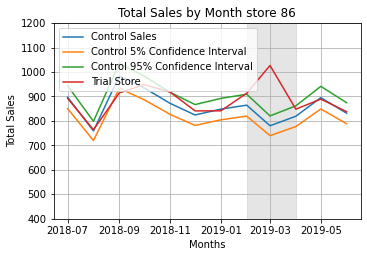

In [93]:
plt.figure(figsize=(5.5, 3.6))
plt.plot(combineSales)
plt.title('Total Sales by Month store 86')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.ylim((400, 1200))
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)
plt.axvspan('2019-02-01', '2019-04-01', color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.savefig('Total Sales by Month store 86 ci.png')
plt.show()



The results show that the trial in store 86 is not significantly different to its control store in the trial period. The trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months

In [94]:
# Now let's move on to 'nCustomers'
# First, compute scaling factor
# Let's call this variable 'scalingFactorCustomers'

trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0

In [95]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == 155]
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/1062885773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,101.0
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,91.0
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,103.0
1796,155,201810,963.8,108,1.259259,2.000000,3.543382,2018-10-01,108.0
1797,155,201811,898.8,101,1.316832,2.030075,3.328889,2018-11-01,101.0


In [96]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == 86, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,101.0,99
1,201808,91.0,94
2,201809,103.0,103
3,201810,108.0,109
4,201811,101.0,100
5,201812,97.0,98
6,201901,96.0,94
7,201902,95.0,107
8,201903,94.0,115
9,201904,99.0,105


In [97]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000
3,201810,108.0,109,0.009259
4,201811,101.0,100,0.009901
5,201812,97.0,98,0.010309
6,201901,96.0,94,0.020833
7,201902,95.0,107,0.126316
8,201903,94.0,115,0.223404
9,201904,99.0,105,0.060606


In [98]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.010687444701395236

In [99]:
#we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [100]:
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7    11.819082
8    20.903430
9     5.670772
Name: tValue, dtype: float64

In [101]:
t.isf(0.05, dof)

1.8945786050613054

In [102]:
controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,101.0
2018-08-01,91.0
2018-09-01,103.0
2018-10-01,108.0
2018-11-01,101.0
2018-12-01,97.0
2019-01-01,96.0
2019-02-01,95.0
2019-03-01,94.0


In [103]:
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == 86, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,99
2018-08-01,94
2018-09-01,103
2018-10-01,109
2018-11-01,100
2018-12-01,98
2019-01-01,94
2019-02-01,107
2019-03-01,115


In [104]:
controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,101.0,98.841136,103.158864
2018-08-01,91.0,89.054885,92.945115
2018-09-01,103.0,100.798386,105.201614
2018-10-01,108.0,105.691512,110.308488
2018-11-01,101.0,98.841136,103.158864
2018-12-01,97.0,94.926636,99.073364
2019-01-01,96.0,93.948011,98.051989
2019-02-01,95.0,92.969386,97.030614
2019-03-01,94.0,91.990760,96.009240


In [105]:
combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,101.0,98.841136,103.158864,99
2018-08-01,91.0,89.054885,92.945115,94
2018-09-01,103.0,100.798386,105.201614,103
2018-10-01,108.0,105.691512,110.308488,109
2018-11-01,101.0,98.841136,103.158864,100
2018-12-01,97.0,94.926636,99.073364,98
2019-01-01,96.0,93.948011,98.051989,94
2019-02-01,95.0,92.969386,97.030614,107
2019-03-01,94.0,91.990760,96.009240,115


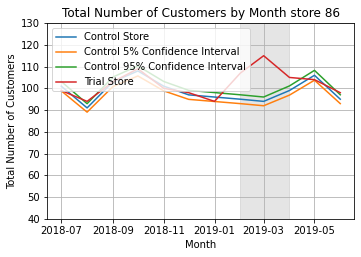

In [106]:
plt.figure(figsize=(5.5, 3.6))
plt.plot(combineCustomers)
plt.title('Total Number of Customers by Month store 86')
plt.xlabel('Month')
plt.ylabel('Total Number of Customers')
plt.ylim(40,130)
plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 'upper left')
plt.axvspan('2019-02-01', '2019-04-01', color = 'grey', alpha = 0.2)
# Set grid
plt.grid()
plt.savefig('Total Number of Customers by Month store 86 ci.png')
plt.show()


The number of customers is significantly higher in all of the three months. This shows that the trial had a significant impact on increasing the number of customers in trial store 86 but, sales were not significantly higher. 

### Selecting control store for trial store 88

In [107]:
#correlation for sales and customers with trial store 88
corr_nSales = calc_corr(preTrialMeasures, 'totSales', 88)
corr_nCustomers = calc_corr(preTrialMeasures, 'nCustomers', 88)

#magnitude for sales and customers with trial store 88
magnitude_nSales = calc_mag(preTrialMeasures, 'totSales', 88)
magnitude_nCustomers = calc_mag(preTrialMeasures, 'nCustomers', 88)

for nSales

In [108]:
print(corr_nSales.head())
magnitude_nSales.head()

   Store1  Store2  Correlation
0    88.0     1.0     0.813636
1    88.0     2.0    -0.067927
2    88.0     3.0    -0.507847
3    88.0     4.0    -0.745566
4    88.0     5.0     0.190330


,Store1,Store2,Magnitude
0,88.0,1.0,0.548959
1,88.0,2.0,0.541212
2,88.0,3.0,0.458109
3,88.0,4.0,0.484447
4,88.0,5.0,0.496409


In [109]:
#concatenate score for nSales
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis =1)

In [110]:
#calculating weighted average

score_nSales['scoreNSales'] = 0.5 * score_nSales['Correlation'] + (0.5 * score_nSales['Magnitude'])
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,88.0,1.0,0.813636,0.548959,0.681297
1,88.0,2.0,-0.067927,0.541212,0.236643
2,88.0,3.0,-0.507847,0.458109,-0.024869
3,88.0,4.0,-0.745566,0.484447,-0.130559
4,88.0,5.0,0.190330,0.496409,0.343370


for nCustomers now

In [111]:
print(corr_nCustomers.head())
magnitude_nCustomers.head()

   Store1  Store2  Correlation
0    88.0     1.0     0.305334
1    88.0     2.0    -0.452379
2    88.0     3.0     0.522884
3    88.0     4.0    -0.361503
4    88.0     5.0    -0.025320


,Store1,Store2,Magnitude
0,88.0,1.0,0.357143
1,88.0,2.0,0.285714
2,88.0,3.0,0.683673
3,88.0,4.0,0.577922
4,88.0,5.0,0.558442


In [112]:
#concatenate score for nCustomers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis =1)

In [113]:
#calculating weighted average

score_nCustomers['scoreNCust'] = 0.5 * score_nCustomers['Correlation'] + (0.5 * score_nCustomers['Magnitude'])
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,88.0,1.0,0.305334,0.357143,0.331238
1,88.0,2.0,-0.452379,0.285714,-0.083332
2,88.0,3.0,0.522884,0.683673,0.603279
3,88.0,4.0,-0.361503,0.577922,0.108210
4,88.0,5.0,-0.025320,0.558442,0.266561


In [114]:
#Index both 'score_nSales' and 'score_nCustomers' dataframe to aid merging

score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

In [115]:
#new dataframe 'score_Control' which takes the average of 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
88.0   1.0        0.681297    0.331238
       2.0        0.236643   -0.083332
       3.0       -0.024869    0.603279
       4.0       -0.130559    0.108210
       5.0        0.343370    0.266561
...                    ...         ...
       268.0      0.250709    0.651462
       269.0      0.196139    0.043061
       270.0     -0.104971    0.132467
       271.0      0.163091    0.318507
       272.0     -0.077482    0.237944

[260 rows x 2 columns]

In [116]:
#adding a column into control_score which gives a finalscore ( average of sales and customer score)
score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
88.0   1.0        0.681297    0.331238           0.506268
       2.0        0.236643   -0.083332           0.076655
       3.0       -0.024869    0.603279           0.289205
       4.0       -0.130559    0.108210          -0.011175
       5.0        0.343370    0.266561           0.304965

In [117]:
#Now we sort by final score to get the control store for trial store 88
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
88.0   178.0      0.650803    0.707828           0.679316
       14.0       0.646064    0.685774           0.665919
       134.0      0.775084    0.540154           0.657619
       237.0      0.451974    0.777235           0.614604
       187.0      0.616752    0.594560           0.605656

Store 178 is the probable control store for trial store 88

In [118]:
#new dataframe from preTrialMaasures Df
pastSales = preTrialMeasures

store_type = []

for i in pastSales['STORE_NBR']:
    if i == 88:
        store_type.append('Trial Store')
    elif i == 178:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/165954221.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [119]:
#create a transaction month column
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/3201636428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


Text(0.5, 1.0, 'Total Sales by Month')

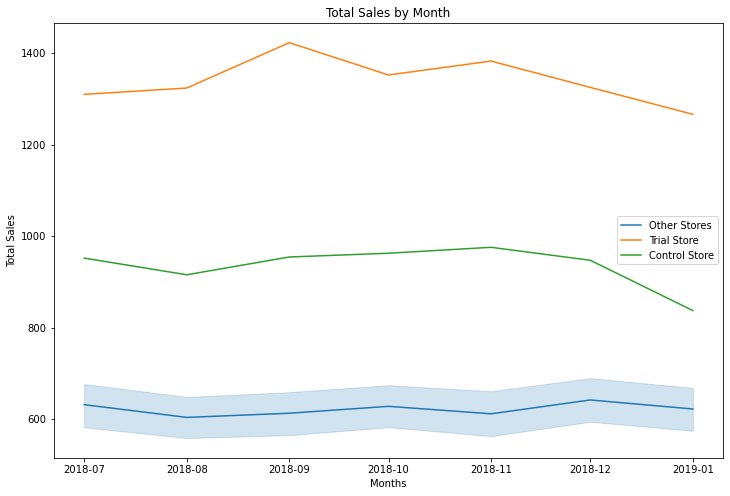

In [120]:
#  'totSales' visualisation for control store, trial store and other stores

plt.figure(figsize =(12, 8))
g= sns.lineplot(data= pastSales, x = 'TransactionMonth', y='totSales', hue='store_type')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Total Sales by Month')

In [121]:
#new dataframe from preTrialMaasures Df
pastSales = preTrialMeasures

store_type = []

for i in pastSales['STORE_NBR']:
    if i == 88:
        store_type.append('Trial Store')
    elif i == 14:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/3231256571.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


Text(0.5, 1.0, 'Total Sales by Month')

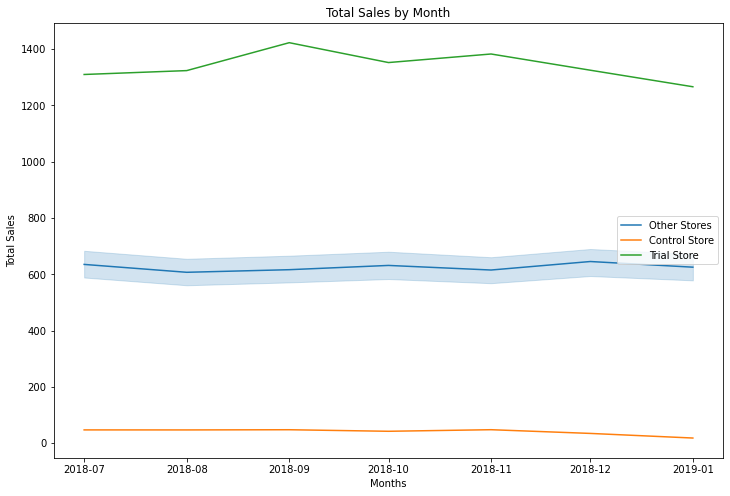

In [122]:
#  'totSales' visualisation for control store, trial store and other stores

plt.figure(figsize =(12, 8))
g= sns.lineplot(data= pastSales, x = 'TransactionMonth', y='totSales', hue='store_type')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Total Sales by Month')

In [123]:
#new dataframe from preTrialMaasures Df
pastSales = preTrialMeasures

store_type = []

for i in pastSales['STORE_NBR']:
    if i == 88:
        store_type.append('Trial Store')
    elif i == 134:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/2179569614.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


Text(0.5, 1.0, 'Total Sales by Month')

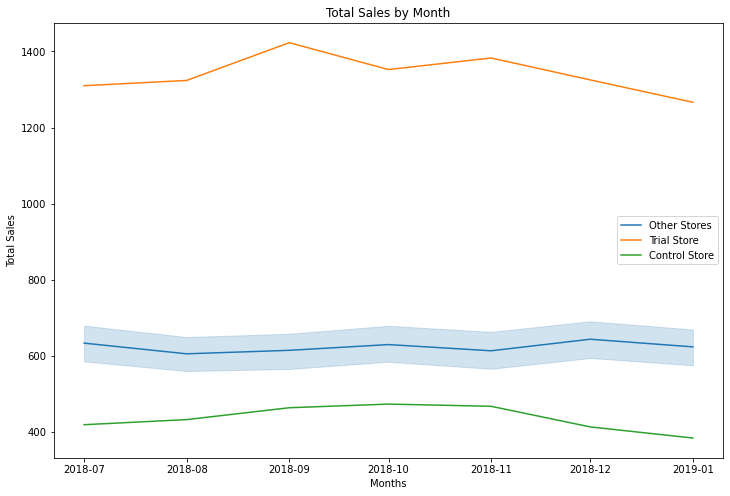

In [124]:
#  'totSales' visualisation for control store, trial store and other stores

plt.figure(figsize =(12, 8))
g= sns.lineplot(data= pastSales, x = 'TransactionMonth', y='totSales', hue='store_type')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Total Sales by Month')

In [125]:
#new dataframe from preTrialMaasures Df
pastSales = preTrialMeasures

store_type = []

for i in pastSales['STORE_NBR']:
    if i == 88:
        store_type.append('Trial Store')
    elif i == 237:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/3684303167.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pastSales['store_type'] = store_type


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


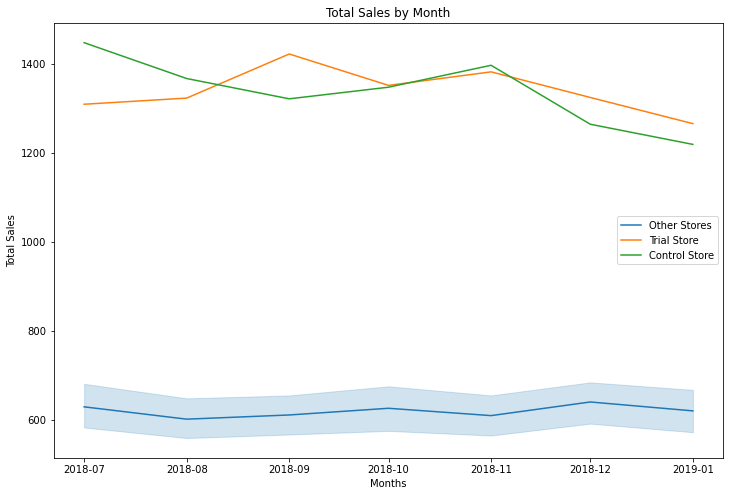

In [126]:
#  'totSales' visualisation for control store, trial store and other stores

plt.figure(figsize =(12, 8))
g= sns.lineplot(data= pastSales, x = 'TransactionMonth', y='totSales', hue='store_type')
plt.ylabel('Total Sales')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Total Sales by Month')
plt.savefig('Total Sales by Month store 88 .png')

### Store 237 is the control store for trial store 88

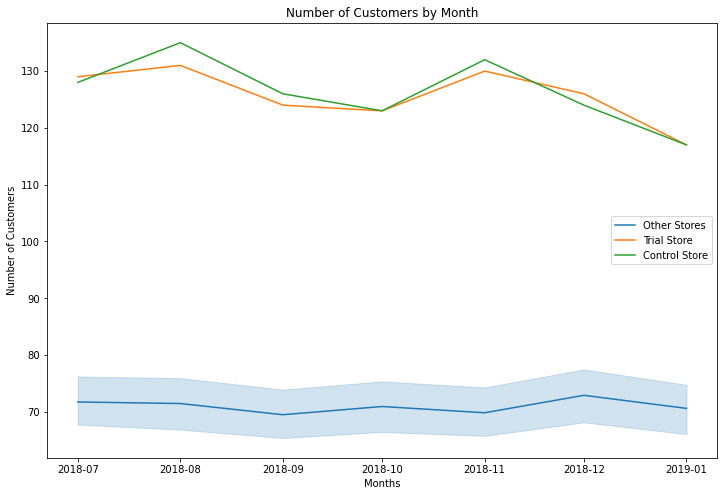

In [127]:
#  'nCustomers' visualisation for control store, trial store and other stores
plt.figure(figsize =(12, 8))
g =sns.lineplot(data= pastSales, x = 'TransactionMonth', y='nCustomers', hue='store_type')
plt.ylabel('Number of Customers')
plt.xlabel('Months')
plt.legend(loc='center right')
plt.title('Number of Customers by Month')
plt.savefig('Number of Customers by Month store 88 .png')

Assessment of trial for trial strore 88

In [128]:
# create scaling factor; compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control stor

trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.001558330664959

In [129]:
#create new df from measureovertime (before we filtered with pretrial date)
scaledControlSales = measureOverTime
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [130]:
#we only want for the control store
scaledControlSales = scaledControlSales[scaledControlSales['STORE_NBR'] == 237]
scaledControlSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01


In [131]:
# new colum 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/2095262402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,1450.657086
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,1369.931485
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,1324.260425
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,1350.401097
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,1399.777923


In [132]:
# Create 'percentageDiff' dataframe which computes diff between controledsales and trial sales

#control store 'totSales'
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == 88, 'totSales']
trialSales.reset_index(drop = True, inplace = True)

# Concatenate
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)



percentageDiff

,YEARMONTH,controlSales,trialSales
0,201807,1450.657086,1310.00
1,201808,1369.931485,1323.80
2,201809,1324.260425,1423.00
3,201810,1350.401097,1352.40
4,201811,1399.777923,1382.80
5,201812,1266.971288,1325.20
6,201901,1221.600696,1266.40
7,201902,1406.989143,1370.20
8,201903,1210.082775,1477.20
9,201904,1206.477165,1439.40


In [133]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,1450.657086,1310.00,0.096961
1,201808,1369.931485,1323.80,0.033674
2,201809,1324.260425,1423.00,0.074562
3,201810,1350.401097,1352.40,0.001480
4,201811,1399.777923,1382.80,0.012129
5,201812,1266.971288,1325.20,0.045959
6,201901,1221.600696,1266.40,0.036673
7,201902,1406.989143,1370.20,0.026147
8,201903,1210.082775,1477.20,0.220743
9,201904,1206.477165,1439.40,0.193060


In [134]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev
#standard deviation between percentage diff before trial period

0.0334678673030788

In [135]:
# Since we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [136]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7    0.781270
8    6.595668
9    5.768527
Name: tValue, dtype: float64

In [137]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

1.8945786050613054

In [138]:
#recall ScaledControlSales
scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/801860965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlSales
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,1450.657086
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,1369.931485
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,1324.260425
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,1350.401097
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,1399.777923


In [139]:
#visualisation
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store 

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales.head()

,Control Sales
TransactionMonth,
2018-07-01,1450.657086
2018-08-01,1369.931485
2018-09-01,1324.260425
2018-10-01,1350.401097
2018-11-01,1399.777923


In [140]:
#new 'TransationMonth'column under 'measureOverTime' dataframe

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEARMONTH'].astype(str), format = '%Y%m')

#extract totsales for trial store from measureOvertime to get trial sales
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == 88, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)

In [141]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,1450.657086,1353.556288,1547.757884
2018-08-01,1369.931485,1278.234114,1461.628855
2018-09-01,1324.260425,1235.620080,1412.900769
2018-10-01,1350.401097,1260.011008,1440.791187
2018-11-01,1399.777923,1306.082759,1493.473086


In [142]:
combineSales = pd.concat([controlSales, trialSales], axis=1)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,1450.657086,1353.556288,1547.757884,1310.00
2018-08-01,1369.931485,1278.234114,1461.628855,1323.80
2018-09-01,1324.260425,1235.620080,1412.900769,1423.00
2018-10-01,1350.401097,1260.011008,1440.791187,1352.40
2018-11-01,1399.777923,1306.082759,1493.473086,1382.80
2018-12-01,1266.971288,1182.165634,1351.776942,1325.20
2019-01-01,1221.600696,1139.831956,1303.369436,1266.40
2019-02-01,1406.989143,1312.811291,1501.166995,1370.20
2019-03-01,1210.082775,1129.084996,1291.080555,1477.20


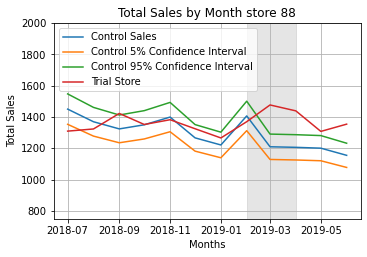

In [143]:
plt.figure(figsize=(5.5, 3.6))
plt.plot(combineSales)
plt.title('Total Sales by Month store 88')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.ylim((750, 2000))
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)
plt.axvspan('2019-02-01', '2019-04-01', color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.savefig('Total Sales by Month store 88 ci.png')
plt.show()


The results show that the trial in store 88 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [144]:
# Now let's move on to 'nCustomers'
# First, compute scaling factor
# Let's call this variable 'scalingFactorCustomers'

trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

0.9943502824858758

In [145]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == 237]
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

C:\Users\seun\AppData\Local\Temp/ipykernel_4736/2375013937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
2747,237,201807,1448.4,128,1.265625,2.000000,4.470370,2018-07-01,127.276836
2748,237,201808,1367.8,135,1.222222,1.896970,4.369968,2018-08-01,134.237288
2749,237,201809,1322.2,126,1.182540,2.006711,4.422074,2018-09-01,125.288136
2750,237,201810,1348.3,123,1.195122,2.034014,4.509365,2018-10-01,122.305085
2751,237,201811,1397.6,132,1.219697,1.987578,4.367500,2018-11-01,131.254237


In [146]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == 88, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,127.276836,129
1,201808,134.237288,131
2,201809,125.288136,124
3,201810,122.305085,123
4,201811,131.254237,130
5,201812,123.299435,126
6,201901,116.338983,117
7,201902,125.288136,124
8,201903,118.327684,134
9,201904,119.322034,128


In [147]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,127.276836,129,0.013539
1,201808,134.237288,131,0.024116
2,201809,125.288136,124,0.010281
3,201810,122.305085,123,0.005682
4,201811,131.254237,130,0.009556
5,201812,123.299435,126,0.021902
6,201901,116.338983,117,0.005682
7,201902,125.288136,124,0.010281
8,201903,118.327684,134,0.132448
9,201904,119.322034,128,0.072727


In [148]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.00741024435207507

In [149]:
#we have 8 pre-trial months, dof = 8 - 1 = 7

dof = 7

In [150]:
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     1.387456
8    17.873693
9     9.814423
Name: tValue, dtype: float64

In [151]:
t.isf(0.05, dof)

1.8945786050613054

In [152]:
controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,127.276836
2018-08-01,134.237288
2018-09-01,125.288136
2018-10-01,122.305085
2018-11-01,131.254237
2018-12-01,123.299435
2019-01-01,116.338983
2019-02-01,125.288136
2019-03-01,118.327684


In [153]:
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == 88, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,129
2018-08-01,131
2018-09-01,124
2018-10-01,123
2018-11-01,130
2018-12-01,126
2019-01-01,117
2019-02-01,124
2019-03-01,134


In [154]:
controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,127.276836,125.390531,129.163141
2018-08-01,134.237288,132.247826,136.226750
2018-09-01,125.288136,123.431304,127.144967
2018-10-01,122.305085,120.492464,124.117706
2018-11-01,131.254237,129.308985,133.199489
2018-12-01,123.299435,121.472077,125.126793
2019-01-01,116.338983,114.614782,118.063184
2019-02-01,125.288136,123.431304,127.144967
2019-03-01,118.327684,116.574010,120.081358


In [155]:
combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,127.276836,125.390531,129.163141,129
2018-08-01,134.237288,132.247826,136.226750,131
2018-09-01,125.288136,123.431304,127.144967,124
2018-10-01,122.305085,120.492464,124.117706,123
2018-11-01,131.254237,129.308985,133.199489,130
2018-12-01,123.299435,121.472077,125.126793,126
2019-01-01,116.338983,114.614782,118.063184,117
2019-02-01,125.288136,123.431304,127.144967,124
2019-03-01,118.327684,116.574010,120.081358,134


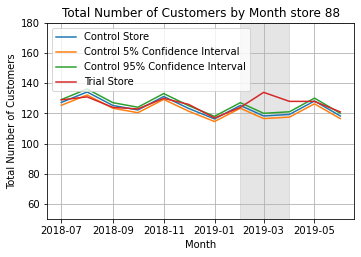

In [156]:
plt.figure(figsize=(5.5, 3.6))
plt.plot(combineCustomers)
plt.title('Total Number of Customers by Month store 88')
plt.xlabel('Month')
plt.ylabel('Total Number of Customers')
plt.ylim(50,180)
plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 'upper left')
plt.axvspan('2019-02-01', '2019-04-01', color = 'grey', alpha = 0.2)
# Set grid
plt.grid()
plt.savefig('Total Number of Customers by Month store 88 ci.png')
plt.show()


The number of customers is significantly higher in two of the three months. This shows that the trial had a significant impact on increasing the number of customers in trial store 88.